<a href="https://colab.research.google.com/github/sanchit2843/MusicGenreClassification/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive('1SKW6aNswBzWhG-LylVopaHTgz60mBLnx',
                                    dest_path='/content/genre.zip'
                                    )
gdd.download_file_from_google_drive('1tIxKbROqtlHqk1COuuc9VFd3Iq5zVcvP',
                                    dest_path='/content/genre_small.csv'
                                    )


In [2]:
!git clone https://github.com/sanchit2843/MusicGenreClassification
%cd MusicGenreClassification

Cloning into 'MusicGenreClassification'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 229 (delta 57), reused 50 (delta 11), pack-reused 99
Receiving objects: 100% (229/229), 1.02 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/MusicGenreClassification


In [4]:
!mkdir genre
import zipfile
zip_ref = zipfile.ZipFile('/content/genre.zip', 'r')
zip_ref.extractall('/content/genre')
zip_ref.close()

mkdir: cannot create directory ‘genre’: File exists


In [0]:
import pandas as pd
data = pd.read_csv('/content/genre_small.csv')
label = {}
y = data.iloc[:,1:2].values
ID = data.iloc[:,0:1].values
y = y[2:,:]
ID = ID[2:,:]

#Dictionary of labels
for i,j in zip(ID,y):
  label[str(i[0])] = j[0]

In [6]:
print(label)

{'2': 'Hip-Hop', '5': 'Hip-Hop', '10': 'Pop', '140': 'Folk', '141': 'Folk', '148': 'Experimental', '182': 'Rock', '190': 'Folk', '193': 'Folk', '194': 'Folk', '197': 'Folk', '200': 'Folk', '203': 'Folk', '204': 'Folk', '207': 'Folk', '210': 'Folk', '211': 'Folk', '212': 'Folk', '213': 'Pop', '255': 'Rock', '256': 'Rock', '368': 'Rock', '424': 'Experimental', '459': 'Rock', '534': 'Folk', '540': 'Folk', '546': 'Folk', '574': 'Rock', '602': 'Folk', '615': 'Experimental', '620': 'Folk', '621': 'Folk', '625': 'Folk', '666': 'International', '667': 'International', '676': 'Hip-Hop', '690': 'Rock', '694': 'Hip-Hop', '695': 'Hip-Hop', '704': 'International', '705': 'International', '706': 'International', '707': 'International', '708': 'International', '709': 'International', '714': 'Folk', '715': 'Folk', '716': 'Folk', '718': 'Folk', '777': 'Rock', '814': 'Folk', '821': 'Pop', '822': 'Pop', '825': 'Rock', '853': 'International', '890': 'Folk', '892': 'Folk', '897': 'Experimental', '993': 'Ro

In [0]:
#Encoder and decoder of classes
decoder = {}
decoder[0] ='Hip-Hop' 
decoder[1] = 'Pop'
decoder[2] = 'Rock'
decoder[3] = 'Experimental'
decoder[4] = 'Folk'
decoder[5] = 'Instrumental'
decoder[6] = 'Electronic'
decoder[7] = 'International'
encoder = {}
encoder['Hip-Hop'] = 0
encoder['Pop'] = 1
encoder['Rock'] = 2
encoder['Experimental'] = 3
encoder['Folk'] = 4
encoder['Instrumental'] = 5
encoder['Electronic'] = 6
encoder['International'] = 7

In [0]:
from torch.utils.data import Dataset
import os
import cv2
import numpy as np

class genre_data(Dataset):
    def __init__(self,label,image_dir,encoder,transform = None):
      self.img_dir = image_dir
      self.label = label
      self.directory = os.listdir(self.img_dir)
      self.transform = transform
      self.encoder = encoder
    def __len__(self):
      return len(os.listdir(self.img_dir))
      
    def __getitem__(self,idx):
      file_name = self.directory[idx]
      path = os.path.join(self.img_dir,file_name)
      image = cv2.imread(path)
      file_name = file_name[:-6]
      file_name = "".join(file_name)
      genre = self.label.get(file_name,'notfound')
      if genre == 'notfound':
        print("not found wtf")
      genre = self.encoder[genre]
      #genre = np.asarray(genre)
      if(self.transform):
        image = self.transform(image)
      return  image,genre

In [0]:
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from dataloader import data_loader   
im_size = 128
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
inv_normalize = transforms.Normalize([-1,-1,-1],[2,2,2])
data = genre_data(label,'/content/genre',encoder,train_transforms)

In [0]:
dataloaders = data_loader(data,valid_size = 0.1,test_size = 0.1,batch_size = 64)

In [0]:
def class_plot(data , decoder ,inv_normalize = None,n_figures = 12):
    print('Printing random data from dataset')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        label = int(label)
        l = decoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)

        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()

Printing random data from dataset


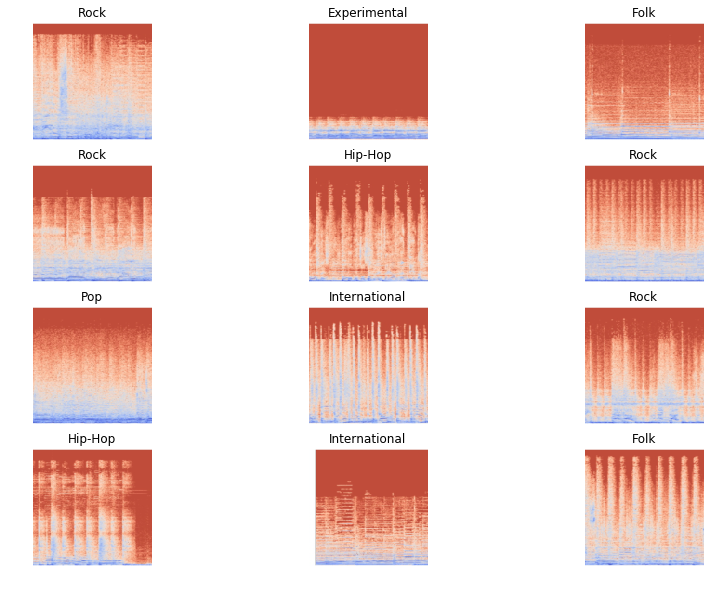

In [12]:
import matplotlib.pyplot as plt
import random
class_plot(data,decoder,inv_normalize)

In [15]:
# Model
!pip install efficientnet_pytorch
import torch
from torch import nn
from torchvision import models
from model import dense121
model = dense121().to('cuda')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 73196623.85it/s]


In [14]:
!pip install adabound
from torch.autograd import Variable
from lib.Earlystopping import EarlyStopping
from lib.lr_finder import LRFinder
from lib.onecycle import OneCycle
from lib.util import *
import adabound

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Epoch: 0
[Epoch 0/10] [Batch 124/125] [Loss: 1.562358 (1.565589), Acc: 37.70% (42.89%)]val Accuracy: 42.88795992714026
Epoch: 1
[Epoch 1/10] [Batch 124/125] [Loss: 1.173795 (1.312199), Acc: 65.57% (53.61%)]val Accuracy: 53.606621129326044
Epoch: 2
[Epoch 2/10] [Batch 124/125] [Loss: 1.267883 (1.219346), Acc: 55.74% (57.06%)]val Accuracy: 57.05537795992714
Epoch: 3
[Epoch 3/10] [Batch 124/125] [Loss: 1.166905 (1.155995), Acc: 60.66% (59.52%)]val Accuracy: 59.5222495446266
Epoch: 4
[Epoch 4/10] [Batch 124/125] [Loss: 1.476101 (1.104777), Acc: 59.02% (61.70%)]val Accuracy: 61.69718123861566
Epoch: 5
[Epoch 5/10] [Batch 124/125] [Loss: 1.035021 (0.936872), Acc: 62.30% (67.33%)]val Accuracy: 67.33481785063752
Epoch: 6
[Epoch 6/10] [Batch 124/125] [Loss: 0.910303 (0.752072), Acc: 70.49% (73.95%)]val Accuracy: 73.94738160291438
Epoch: 7
[Epoch 7/10] [Batch 124/125] [Loss: 0.726484 (0.535999), Acc: 75.41% (81.53%)]val Accuracy: 81.53341985428051
Epoch: 8
[Epoch 8/10] [Batch 124/125] [Loss: 0.2

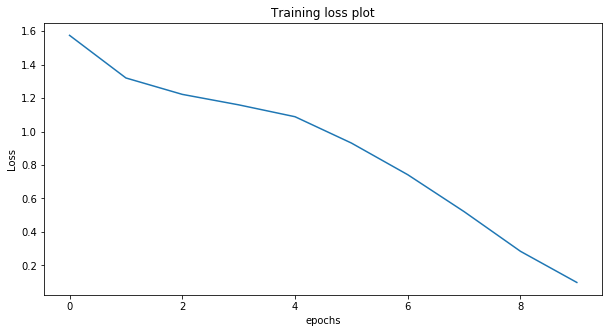

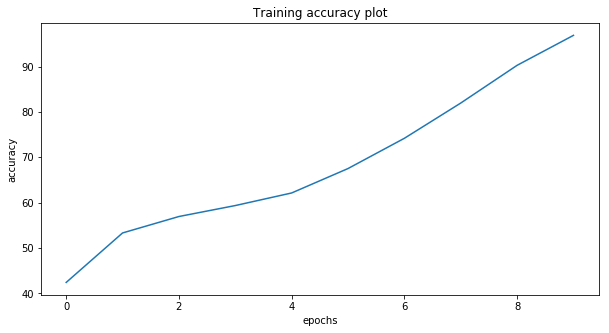

tensor(0.8559, device='cuda:0', dtype=torch.float64) 0.5175359180346132
Classes in order Actual and Predicted


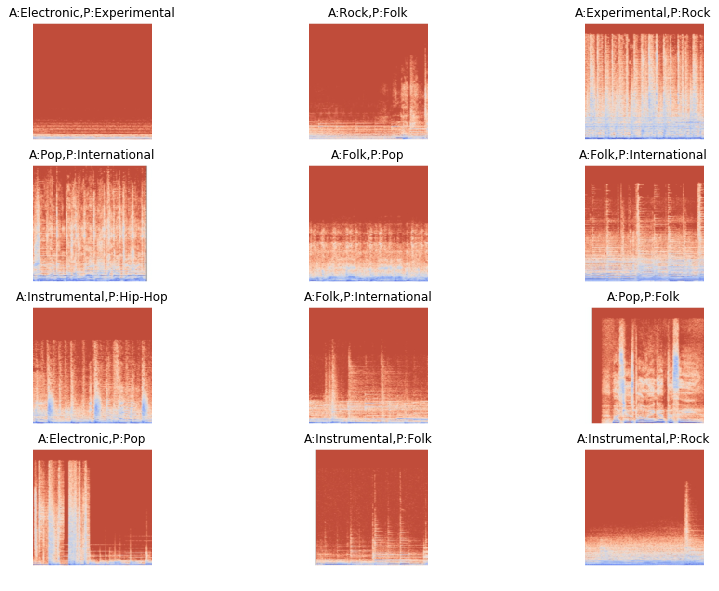

Precision: 85.60761599555498 Recall: 85.63685283102103, Accuracy: 85.61960735275728: ,f1_score: 85.61706880689528


In [16]:
from train import train_model
l1,a1 = train_model(model,dataloaders,decoder,inv_normalize = inv_normalize,num_epochs = 10,lr = 1e-3,batch_size = 64)

In [0]:
#Unfreeze initial layers
for param in model.parameters():
  param.requires_grad = True

Epoch: 0
[Epoch 0/5] [Batch 124/125] [Loss: 0.768067 (0.293745), Acc: 80.33% (90.25%)]val Accuracy: 90.25418032786885
Epoch: 1
[Epoch 1/5] [Batch 124/125] [Loss: 0.689244 (0.285645), Acc: 78.69% (90.38%)]val Accuracy: 90.38383424408015
Epoch: 2
[Epoch 2/5] [Batch 124/125] [Loss: 0.642902 (0.374946), Acc: 86.89% (87.21%)]val Accuracy: 87.20750910746813
Epoch: 3
[Epoch 3/5] [Batch 124/125] [Loss: 0.391782 (0.189077), Acc: 88.52% (93.85%)]val Accuracy: 93.85007741347904
Epoch: 4
[Epoch 4/5] [Batch 124/125] [Loss: 0.738382 (0.069972), Acc: 88.52% (98.23%)]val Accuracy: 98.22868852459015


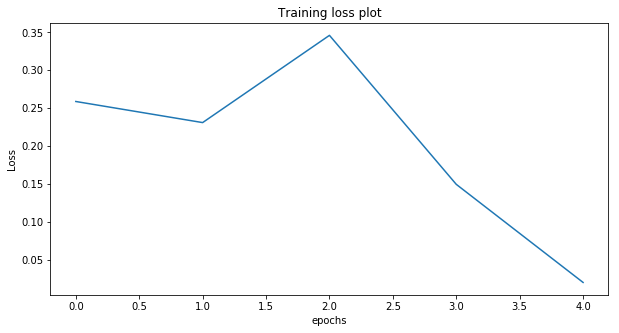

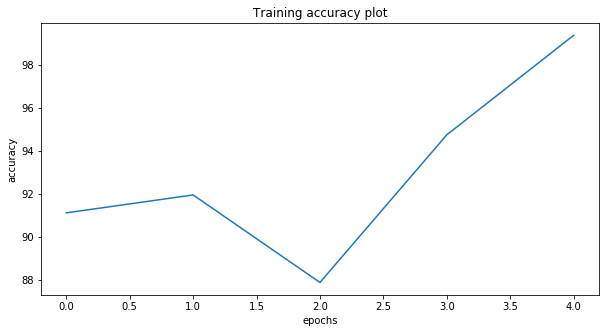

tensor(0.8924, device='cuda:0', dtype=torch.float64) 0.48251728539168837
Classes in order Actual and Predicted


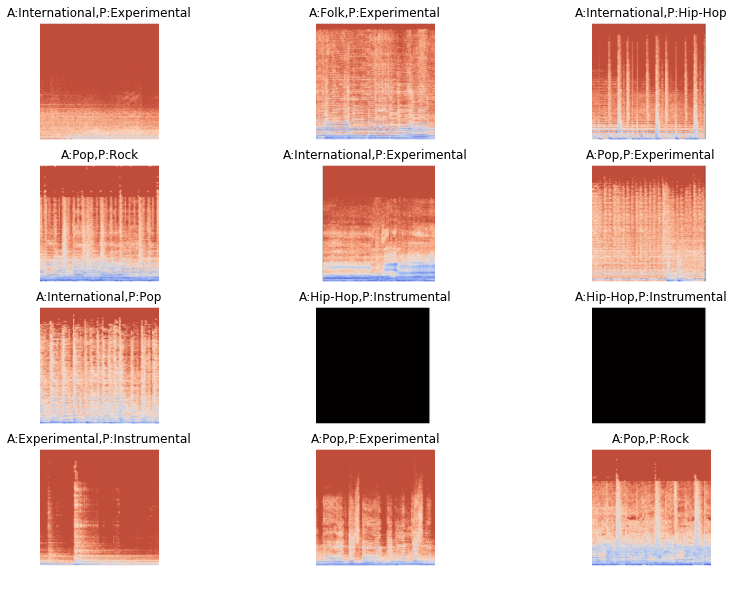

Precision: 89.26833619159069 Recall: 89.29064521146586, Accuracy: 89.2709766162311: ,f1_score: 89.27148173915064


In [19]:
l2,a2 = train_model(model,dataloaders,decoder,inv_normalize = inv_normalize,num_epochs = 5,lr = 1e-4,batch_size = 64)